In [1]:
# import packages

import os
import rasterio
from rasterio.mask import mask
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import geopandas as gpd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Read in data
# Set base file path
file_path = r'E:\Hudson_BGT_RWPR\RandomSampling'

# Import CSV
data_path = file_path + '/20240521TZ_Data.csv'
data = pd.read_csv(data_path)

# Read polygon files
polygon_BGT = gpd.read_file(file_path + '/TZ/Polygon/BGT_boundingBox.shp')
polygon_RWPR = gpd.read_file(file_path + '/TZ/Polygon/RWPR_boundingBox.shp')

# Polygon geometry
geometry_BGT = polygon_BGT.geometry.values[0]
geometry_RWPR = polygon_RWPR.geometry.values[0]

# Read raster files
raster_path = file_path + '/TZ/Rasters'
raster_files = os.listdir(raster_path)

print(data.head())

      ID community  visit   INDEX        date         raster  creatinine  \
0  B001F       BGT      4  B001F4  12/11/2022  _2022_331_345   49.513109   
1  B007F       BGT      4  B007F4  12/11/2022  _2022_331_345  149.887640   
2  B010M       BGT      4  B010M4  12/11/2022  _2022_331_345  121.048689   
3  B012F       BGT      4  B012F4  12/11/2022  _2022_331_345  165.617977   
4  B007F       BGT      3  B007F3   9/19/2022  _2022_248_262  122.172285   

   LOD_UTAS   UTAS_raw    LOD_UV  ...        UW       UPT       UPB       UUR  \
0     0.027   1.635677  0.003085  ...  0.305314  0.019799  0.114520  0.025931   
1     0.027  12.305650  0.003085  ...  0.023859  0.019799  0.535067  0.003947   
2     0.027   6.064023  0.003085  ...  0.033850  0.019799  0.030484  0.012489   
3     0.027  10.725708  0.003085  ...  0.080481  0.019799  0.087293  0.016079   
4     0.027   6.101070  0.003351  ...  0.023610  0.019799  0.260595  0.003753   

        UCD       UMN          SCU          SZN      STA

In [2]:
# Dictionary to store the extracted values
extracted_values = {}

# Loop through rasters to extract by mask and store raster values in lists
for raster_file in raster_files:
    raster_name = os.path.splitext(raster_file)[0]
    raster_full_path = os.path.join(raster_path, raster_file)
    
    with rasterio.open(raster_full_path) as src:
        # Extract values for BGT community
        out_image_BGT, out_transform_BGT = mask(src, [geometry_BGT], crop=True)
        values_BGT = np.array(out_image_BGT).flatten()
        values_BGT = values_BGT[values_BGT != src.nodata]  # Remove no data values
        list_name_BGT = f"BGT_{raster_name}"
        extracted_values[list_name_BGT] = values_BGT.tolist()
        
        # Extract values for RWPR community
        out_image_RWPR, out_transform_RWPR = mask(src, [geometry_RWPR], crop=True)
        values_RWPR = np.array(out_image_RWPR).flatten()
        values_RWPR = values_RWPR[values_RWPR != src.nodata]  # Remove no data values
        list_name_RWPR = f"RWPR_{raster_name}"
        extracted_values[list_name_RWPR] = values_RWPR.tolist()

In [3]:
# Not entirely necessary - just out of curiousity 
# Check for outliers in environmental data
def outlier_proportion(values):
    if len(values) < 4:  # Not enough data to calculate IQR
        return 0
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = [value for value in values if value < lower_bound or value > upper_bound]
    return len(outliers) / len(values)

# Check each list in extracted_values for outliers and print the proportion of outliers if greater than 0%
for list_name, values in extracted_values.items():
    proportion = outlier_proportion(values)
    if proportion > 0:
        print(f"List {list_name} has {proportion:.2%} outliers")

List BGT__2019_125_139 has 1.96% outliers
List RWPR__2019_125_139 has 6.68% outliers
List BGT__2019_223_237 has 1.96% outliers
List BGT__2019_299_313 has 5.88% outliers
List RWPR__2019_299_313 has 5.65% outliers
List BGT__2019_300_314 has 5.88% outliers
List RWPR__2019_300_314 has 4.86% outliers
List RWPR__2019_322_336 has 3.13% outliers
List BGT__2020_026_040 has 7.84% outliers
List RWPR__2020_026_040 has 0.70% outliers
List RWPR__2020_041_055 has 0.42% outliers
List RWPR__2020_043_057 has 0.05% outliers
List BGT__2021_248_262 has 7.84% outliers
List RWPR__2021_248_262 has 0.19% outliers
List BGT__2021_252_266 has 7.84% outliers
List RWPR__2021_252_266 has 0.19% outliers
List RWPR__2021_269_283 has 0.61% outliers
List RWPR__2022_083_097 has 6.96% outliers
List RWPR__2022_149_163 has 0.61% outliers
List RWPR__2022_150_164 has 0.05% outliers
List BGT__2022_248_262 has 1.96% outliers
List RWPR__2022_331_345 has 0.56% outliers


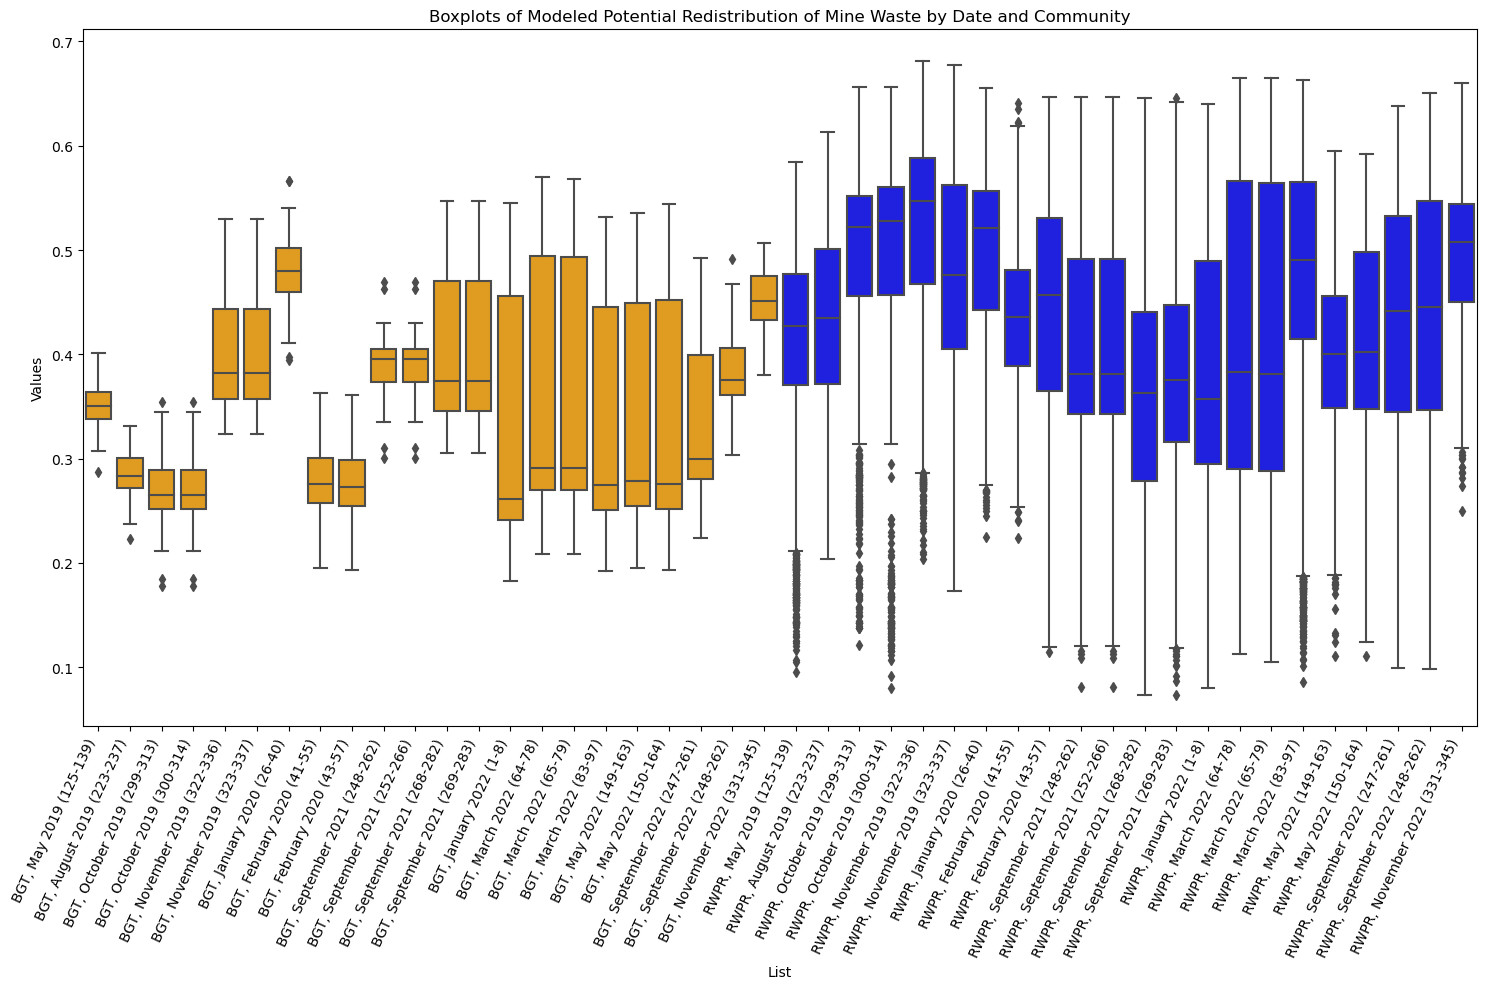

In [4]:
# Plot distribution of raster values
extracted_df = pd.DataFrame({key: pd.Series(value) for key, value in extracted_values.items()})

# Wide to long
melted_df = extracted_df.melt(var_name='List', value_name='Values')

# Alphabetize list
melted_df = melted_df.sort_values('List')

# Function to convert day of the year to month and year label
def day_of_year_to_label(day, year):
    date = datetime(year, 1, 1) + timedelta(days=day - 1)
    return date.strftime("%B %Y")

# Extract year, start day, end day, and community from the list name and convert to label
def convert_list_name_to_label(list_name):
    parts = list_name.split("__")
    community = parts[0]
    year_day = parts[1].split("_")
    year = int(year_day[0])
    start_day = int(year_day[1])
    end_day = int(year_day[2])
    month_year_label = day_of_year_to_label(start_day, year)
    return f"{community}, {month_year_label} ({start_day}-{end_day})"

# Apply the conversion to get intuitive labels
melted_df['IntuitiveLabel'] = melted_df['List'].apply(convert_list_name_to_label)

# Create a color palette
unique_labels = melted_df['IntuitiveLabel'].unique()
palette = ['orange' if 'BGT' in label else 'blue' for label in unique_labels]

# Plot boxplots
plt.figure(figsize=(15, 10))
sns.boxplot(x='IntuitiveLabel', y='Values', data=melted_df, palette=palette)
plt.xticks(rotation=65, ha='right')  # Rotate labels by 65 degrees and align to the right
plt.title('Boxplots of Modeled Potential Redistribution of Mine Waste by Date and Community')
plt.xlabel('List')
plt.ylabel('Values')
plt.tight_layout()
plt.show()


In [5]:
# OPTIONAL: Drop rows by 'visit' to only include pre- or post-zinc supplementation
data = data[~data['visit'].isin([1,2,4])] # Dropping 3 and 4 means that we only have pre-supplementation visits (1 & 2)
print(data['visit'].unique()) # Check which visits are present

[2 1]


# Bootstrap Sampling
## Random Environmental Variables, Stratified by Community

In [6]:
# Stratify by community
# List of analytes
analytes = ['UTAS' # Urine samples start with U, serum with S
          , 'UV'
          , 'USE'
          , 'UFE'
          , 'UBE'
          , 'UCO'
          , 'USR'
          , 'UMO'
          , 'USN'
          , 'USB'
          , 'UCS'
          , 'UBA'
          , 'UW'
          , 'UPT'
          , 'UPB'
          , 'UUR'
          , 'UCD'
          , 'UMN'
          #, 'SCU'
          #, 'SZN'
          #, 'STAS'
          #, 'SSE'
           ]

# Track NA counts across iterations (but won't output to a file)
na_counts = {analyte: {comm: 0 for comm in data['community'].unique()} for analyte in analytes}

for iteration in range(10000):  # Number of iterations
    data['rand_vals'] = np.nan

    # Assign random values to rand_vals based on the extracted values per community-raster key
    for index, row in data.iterrows():
        key = f"{row['community']}_{row['raster']}"
        if key in extracted_values:
            data.at[index, 'rand_vals'] = random.choice(extracted_values[key])

    # Initialize dictionary to store Spearman results for this iteration
    spearman_results = {analyte: {comm: np.nan for comm in data['community'].unique()} for analyte in analytes}

    # Calculate Spearman correlation for each community and analyte
    for community in data['community'].unique():
        community_data = data[data['community'] == community]

        for analyte in analytes:
            # Filter data, keeping only non-NA values for rand_vals and the analyte
            clean_data = community_data.dropna(subset=['rand_vals', analyte])
            na_count = len(community_data) - len(clean_data)
            na_counts[analyte][community] += na_count  # Track NA counts but don't output them

            # Perform Spearman correlation if data is numeric and has more than one unique value
            if pd.api.types.is_numeric_dtype(clean_data[analyte]) and len(clean_data[analyte].unique()) > 1:
                correlation, _ = spearmanr(clean_data['rand_vals'], clean_data[analyte])
                spearman_results[analyte][community] = correlation

    # Append this iteration's results to the overall bootstrap results
    bootstrap_results.append(spearman_results)

# Convert bootstrap results to a DataFrame
flattened_results = []
for result in bootstrap_results:
    for analyte, comm_data in result.items():
        for comm, value in comm_data.items():
            flattened_results.append({'Analyte': analyte, 'Community': comm, 'Spearman_Correlation': value})

bootstrap_df = pd.DataFrame(flattened_results)

# Create the mean Spearman correlation table
mean_spearman = bootstrap_df.groupby(['Community', 'Analyte']).mean().reset_index()

# Pivot the table to get communities as columns and analytes as rows
mean_spearman_pivot = mean_spearman.pivot(index='Analyte', columns='Community', values='Spearman_Correlation')

# Display the average Spearman correlation table (the same as your original code)
print(mean_spearman_pivot)

# Save the average Spearman correlation table to a CSV file (as requested)
mean_output_path = file_path + '/mean_spearman_by_comm.csv'
mean_spearman_pivot.to_csv(mean_output_path)

# Confirm the output path
mean_output_path

# NAs in UTAS (BGT): 1
# NAs in UV (BGT): 1
# NAs in USE (BGT): 1
# NAs in UFE (BGT): 1
# NAs in UBE (BGT): 0
# NAs in UCO (BGT): 1
# NAs in USR (BGT): 1
# NAs in UMO (BGT): 1
# NAs in USN (BGT): 1
# NAs in USB (BGT): 1
# NAs in UCS (BGT): 1
# NAs in UBA (BGT): 1
# NAs in UW (BGT): 1
# NAs in UPT (BGT): 0
# NAs in UPB (BGT): 1
# NAs in UUR (BGT): 1
# NAs in UCD (BGT): 1
# NAs in UMN (BGT): 1
Community       BGT      RWPR
Analyte                      
UBA       -0.047121  0.035720
UBE        0.275050  0.145291
UCD       -0.027351  0.056577
UCO       -0.075987  0.185820
UCS       -0.010452  0.189232
UFE       -0.008190  0.029219
UMN        0.088468  0.056412
UMO       -0.053468  0.109267
UPB        0.218474 -0.099287
UPT        0.169101 -0.055859
USB       -0.051040  0.204767
USE        0.244075 -0.079989
USN       -0.035831  0.155444
USR       -0.005611  0.120594
UTAS       0.108448  0.019234
UUR        0.279489  0.032409
UV         0.010969  0.008926
UW         0.012918  0.103661


'E:\\Hudson_BGT_RWPR\\RandomSampling/mean_spearman_by_comm.csv'

## Pseudo p-value
### Multiple Permutations of Participant Samples

How to characterize significance of bootstrapped correlations:

10k permutations randomly sampling participants - using new permuted distribution, count proportion of the absolute value of the permutations that are larger than the absolute value of the null distribution (the mean of the bootstrapped samples I already have), multiplied by two (because two-sided distribution). If there is no relationship, we expect the proportion to be 0.5: the smaller the proportion, the higher the significance.

2*prob(|rboot|>|rmean|)


In [ ]:
# Number of permutations
n_permutations = 10000  # Adjust this based on desired computational effort

# Initialize list to store permuted results
permutation_results = []

# Permutation loop (for each analyte and each community)
for i in range(n_permutations):
    try:
        # Shuffle the participants (permute the 'rand_vals')
        permuted_data = data.copy()
        permuted_data['rand_vals'] = np.random.permutation(permuted_data['rand_vals'])

        # Dictionary to store spearman rank coefficients for this permutation (all analytes)
        perm_spearman_results = {analyte: {comm: np.nan for comm in data['community'].unique()} for analyte in analytes}

        # Calculate Spearman correlation in the permuted dataset for each analyte-community pair
        for community in permuted_data['community'].unique():
            community_data = permuted_data[permuted_data['community'] == community]
            
            for analyte in analytes:
                clean_data = community_data.dropna(subset=['rand_vals', analyte])
                
                if pd.api.types.is_numeric_dtype(clean_data[analyte]) and len(clean_data[analyte].unique()) > 1:
                    correlation, _ = spearmanr(clean_data['rand_vals'], clean_data[analyte])
                    perm_spearman_results[analyte][community] = correlation

        # Store this iteration's permuted results
        permutation_results.append(perm_spearman_results)
    
    except Exception as e:
        print(f"Error during permutation {i+1}: {str(e)}")
        continue

# Flatten the permutation results
permutation_flattened = []
for result in permutation_results:
    for analyte, comm_data in result.items():
        for comm, value in comm_data.items():
            permutation_flattened.append({'Analyte': analyte, 'Community': comm, 'Spearman_Correlation': value})

permutation_df = pd.DataFrame(permutation_flattened)

# Compute absolute values of the permuted correlations for comparison
permutation_df['Abs_Spearman_Correlation'] = permutation_df['Spearman_Correlation'].abs()

# Initialize a DataFrame to store both Spearman correlations and pseudo p-values
spearman_and_pseudo_p_values = pd.DataFrame(index=mean_abs_spearman.index, columns=pd.MultiIndex.from_product([mean_abs_spearman.columns, ['Spearman_Correlation', 'Pseudo_P_value']]))

# Calculate pseudo p-values and combine them with the Spearman correlation values
for analyte in mean_abs_spearman.index:
    for community in mean_abs_spearman.columns:
        try:
            # Get the mean Spearman correlation for the current analyte-community pair
            mean_spearman_value = mean_abs_spearman.loc[analyte, community]

            if not pd.isna(mean_spearman_value):
                # Get permuted values for the current analyte-community pair
                permuted_values = permutation_df[(permutation_df['Analyte'] == analyte) & (permutation_df['Community'] == community)]['Abs_Spearman_Correlation']

                # Calculate the proportion of permuted correlations greater than or equal to the original
                greater_than_original = (permuted_values >= mean_spearman_value).sum()
                proportion = greater_than_original / n_permutations

                pseudo_p_value = proportion * 2  # Two-sided test

                # Ensure pseudo p-value is not greater than 1.000
                if pseudo_p_value > 1.000:
                    pseudo_p_value = 1.000

                # Store the Spearman correlation and the pseudo p-value in the final DataFrame
                spearman_and_pseudo_p_values.loc[analyte, (community, 'Spearman_Correlation')] = mean_spearman_pivot.loc[analyte, community]
                spearman_and_pseudo_p_values.loc[analyte, (community, 'Pseudo_P_value')] = round(pseudo_p_value, 3)
        
        except Exception as e:
            print(f"Error for analyte {analyte}, community {community}: {str(e)}")
            continue

# Display the combined Spearman correlation and pseudo p-values, formatted to 3 decimal places
pd.options.display.float_format = "{:.3f}".format
print(spearman_and_pseudo_p_values)

# Save the combined results to CSV
combined_output_path = file_path + '/spearman_and_pseudo_p_values_by_comm.csv'
spearman_and_pseudo_p_values.to_csv(combined_output_path)

# Confirm the output path
combined_output_path
